In [1]:
import baltic as bt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import pickle
# from Bio import SeqIO
# import datetime
sns.set(style='whitegrid', font_scale=1.3)

In [2]:
# metadata = { s.strip().split('|')[0].replace('/', '_')[1:] : s.strip()[1:] for s in open('../data/sequences/dengue_all.fasta') if s.startswith('>')}

In [4]:
treestring = open('../../titer_model/implementation-nextstrain-augur/dengue/processed/dengue_all.newick', 'r').readlines()[0].strip()
tree = bt.tree()
bt.make_tree(treestring, tree)
tree.sortBranches()
tree.traverse_tree()
tree.drawTree()

colors = pickle.load(open('../../figures/colors.p', 'rb'))
colors.update({'DENV': (0,0,0,1)})

In [5]:
def get_serotype_mrcas(tree, sep='_'):
    
    serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4']
    
    mrcas = {}
    for s in serotypes:
        within_serotype = [k for k in tree.nodes if 
                           all([w.split(sep)[0] == s 
                                or w.split(sep)[0] == 'DENV' for w in k.leaves])]
        mrca = sorted(within_serotype, key = lambda k: len(k.leaves))[-1]
        mrcas[s] = mrca
    return mrcas
    
serotype_mrcas = get_serotype_mrcas(tree, sep='/')
for sero, mrca in serotype_mrcas.items():
    for w in tree.traverse_tree(mrca):
        w.numName = w.numName.replace(w.numName.split('/')[0], sero)

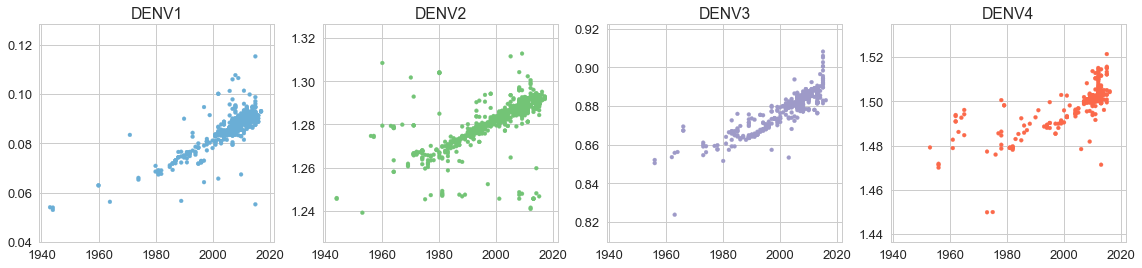

In [6]:
def plot_clock(tree, subtrees = serotype_mrcas, color_map = colors, sep='_'):
    
    def get_clock_vals(leaves):
        dates = []
        divs = []
        colors = []
        for k in leaves:
            try:
                date_val = float(k.numName.split(sep)[-1])
                div_val = k.height
                if color_map is not None:
                    serotype = k.numName.split(sep)[0].strip()
                    color = color_map[serotype]
                dates.append(date_val)
                divs.append(div_val)
                colors.append(color)
            except:
                continue
        return dates, divs, colors
            
    if subtrees is None:
        dates, divs, colors = get_clock_vals(tree.leaves)
        plt.scatter(dates, divs, colors)
    
    else:
        fig, axes = plt.subplots(ncols=len(subtrees.keys()), figsize=(16,4), sharex=True)
        for label, ax in zip(sorted(subtrees.keys()), axes):
            subtree_leaves = tree.traverse_tree(subtrees[label])
            dates, divs, colors = get_clock_vals(subtree_leaves)
            ax.scatter(dates, divs, s=15, c=colors)
            ax.set_title(label)
            
    plt.tight_layout()
    plt.show()

plot_clock(tree, sep='/')

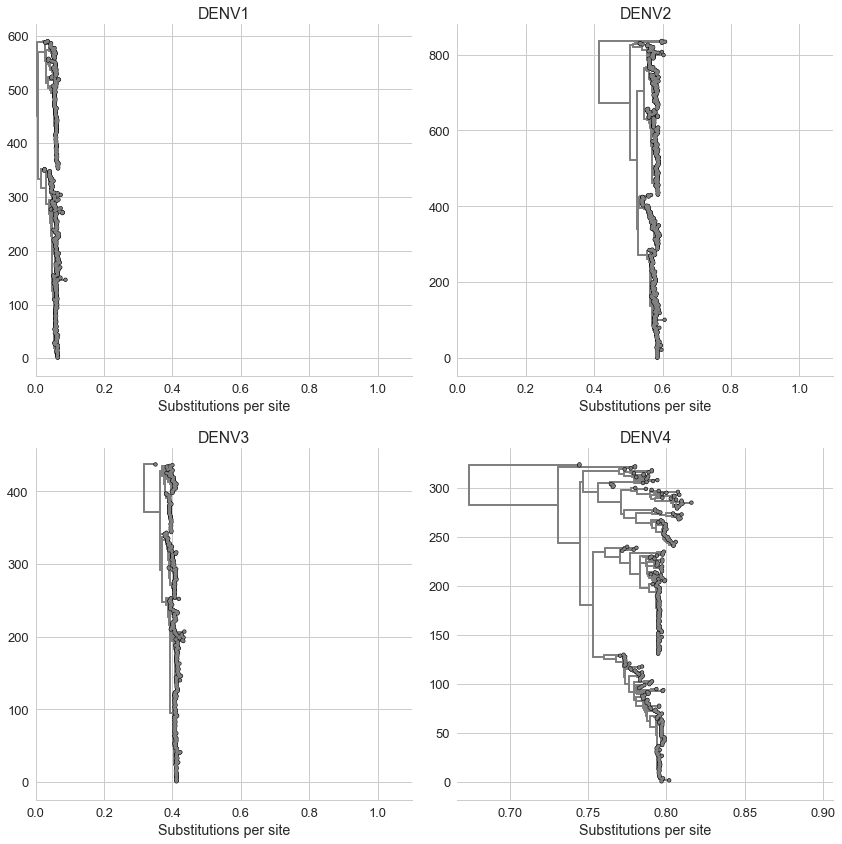

In [7]:
def plot_tree(tree, subtrees = serotype_mrcas, color_map = colors):
        
    def plot_subtree(subtree, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8,12))
        branchWidth=2 ## default branch width
#         ax.set_yticks(size=0)
        for k in subtree.Objects: ## iterate over objects in tree
            x=k.x ## or use absolute time instead
            y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
            xp=k.parent.x ## get x position of current object's parent
            if x==None: ## matplotlib won't plot Nones, like root
                x=0.0
            if xp==None:
                xp=x
            try:
#                 c = color_map[k.numName.split('_')[0]]
                c = color_map(int(k.numName.split('_')[-1]))
            except:
                c = 'gray'
            if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
                s=10 ## tip size can be fixed
                ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
                ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

            elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
                ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
            ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        ax.set_xlabel('Substitutions per site')
        ax.spines['top'].set_visible(False) ## no axes
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.grid(True)
        x0,x1 = plt.xlim()
        ax.set_xlim((x0, x1*1.1))

    if subtrees is None:
        plot_subtree(tree)
        
    else:
        fig, axes = plt.subplots(ncols=2, nrows=int(len(subtrees.keys())/2), figsize=(12,12))
        
        for label, ax in zip(sorted(subtrees.keys()), axes.flatten().flatten()):
            subtree = tree.subtree(subtrees[label],absoluteTime=False)
            subtree.sortBranches()
            subtree.drawTree()
            plot_subtree(subtree, ax)
            ax.set_title(label)
            
    plt.tight_layout()
    plt.show()
    
plot_tree(tree, color_map=colors)